# Assignment

Use Random Forest to prepare a model on fraud data 
treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

Data Description :

Undergrad : person is under graduated or not
Marital.Status : marital status of a person
Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government 
Work Experience : Work experience of an individual person
Urban : Whether that person belongs to urban area or not

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,make_scorer,f1_score
from sklearn.model_selection import GridSearchCV,cross_val_score, train_test_split
from sklearn.tree import  DecisionTreeClassifier
from sklearn import tree

In [2]:
fraud_data = pd.read_csv('Fraud_check.csv')
fraud_data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [3]:
fraud_data.shape

(600, 6)

In [4]:
fraud_data.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [5]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [6]:
fraud_data.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


In [7]:
fraud_data[fraud_data.duplicated()]

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban


<AxesSubplot: xlabel='Urban', ylabel='count'>

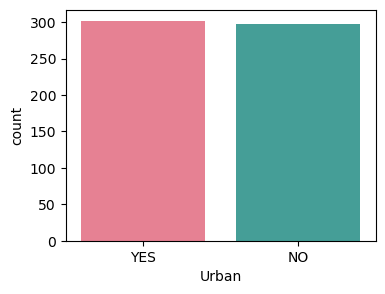

In [8]:
plt.figure(figsize=(4,3))
sns.countplot(x="Urban", data=fraud_data,palette="husl")

<AxesSubplot: xlabel='Marital.Status', ylabel='count'>

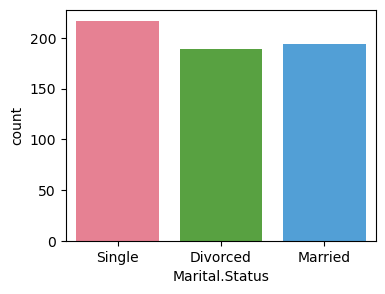

In [9]:
plt.figure(figsize=(4,3))
sns.countplot(x="Marital.Status", data=fraud_data,palette="husl")

<AxesSubplot: xlabel='Undergrad', ylabel='count'>

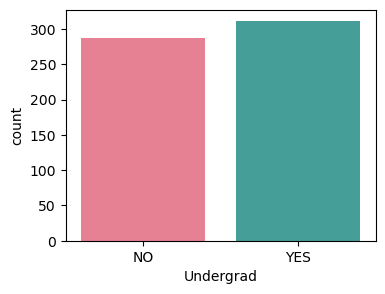

In [10]:
plt.figure(figsize=(4,3))
sns.countplot(x="Undergrad", data=fraud_data,palette="husl")

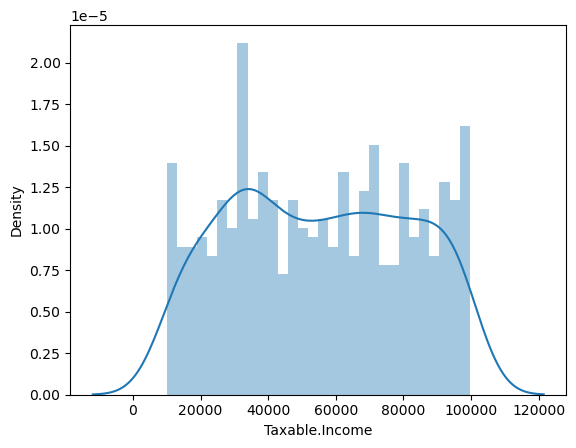

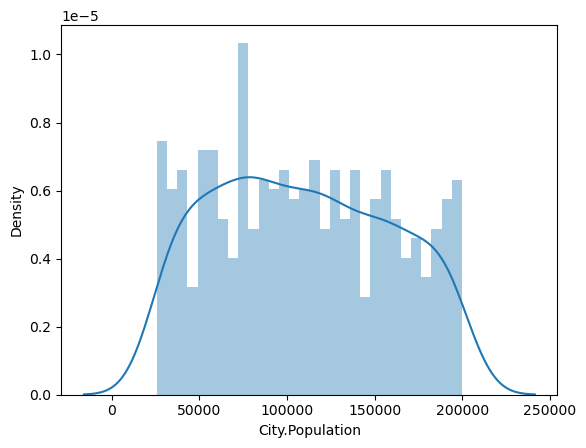

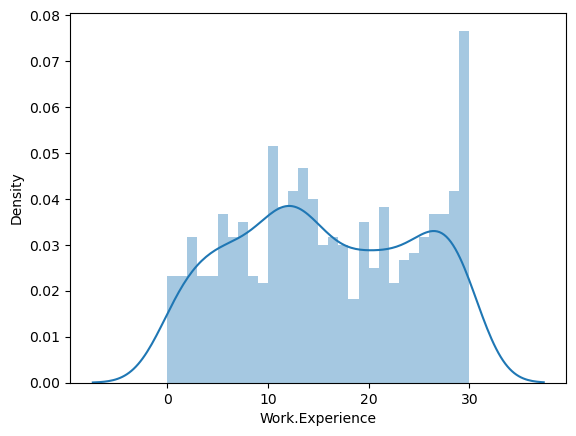

In [11]:
#Distribution for numerical features
numerical_features = [fe for fe in fraud_data.columns if fraud_data[fe].dtype!='O']
for fe in numerical_features:
    sns.distplot(fraud_data[fe],bins=30)
    plt.show()

<AxesSubplot: >

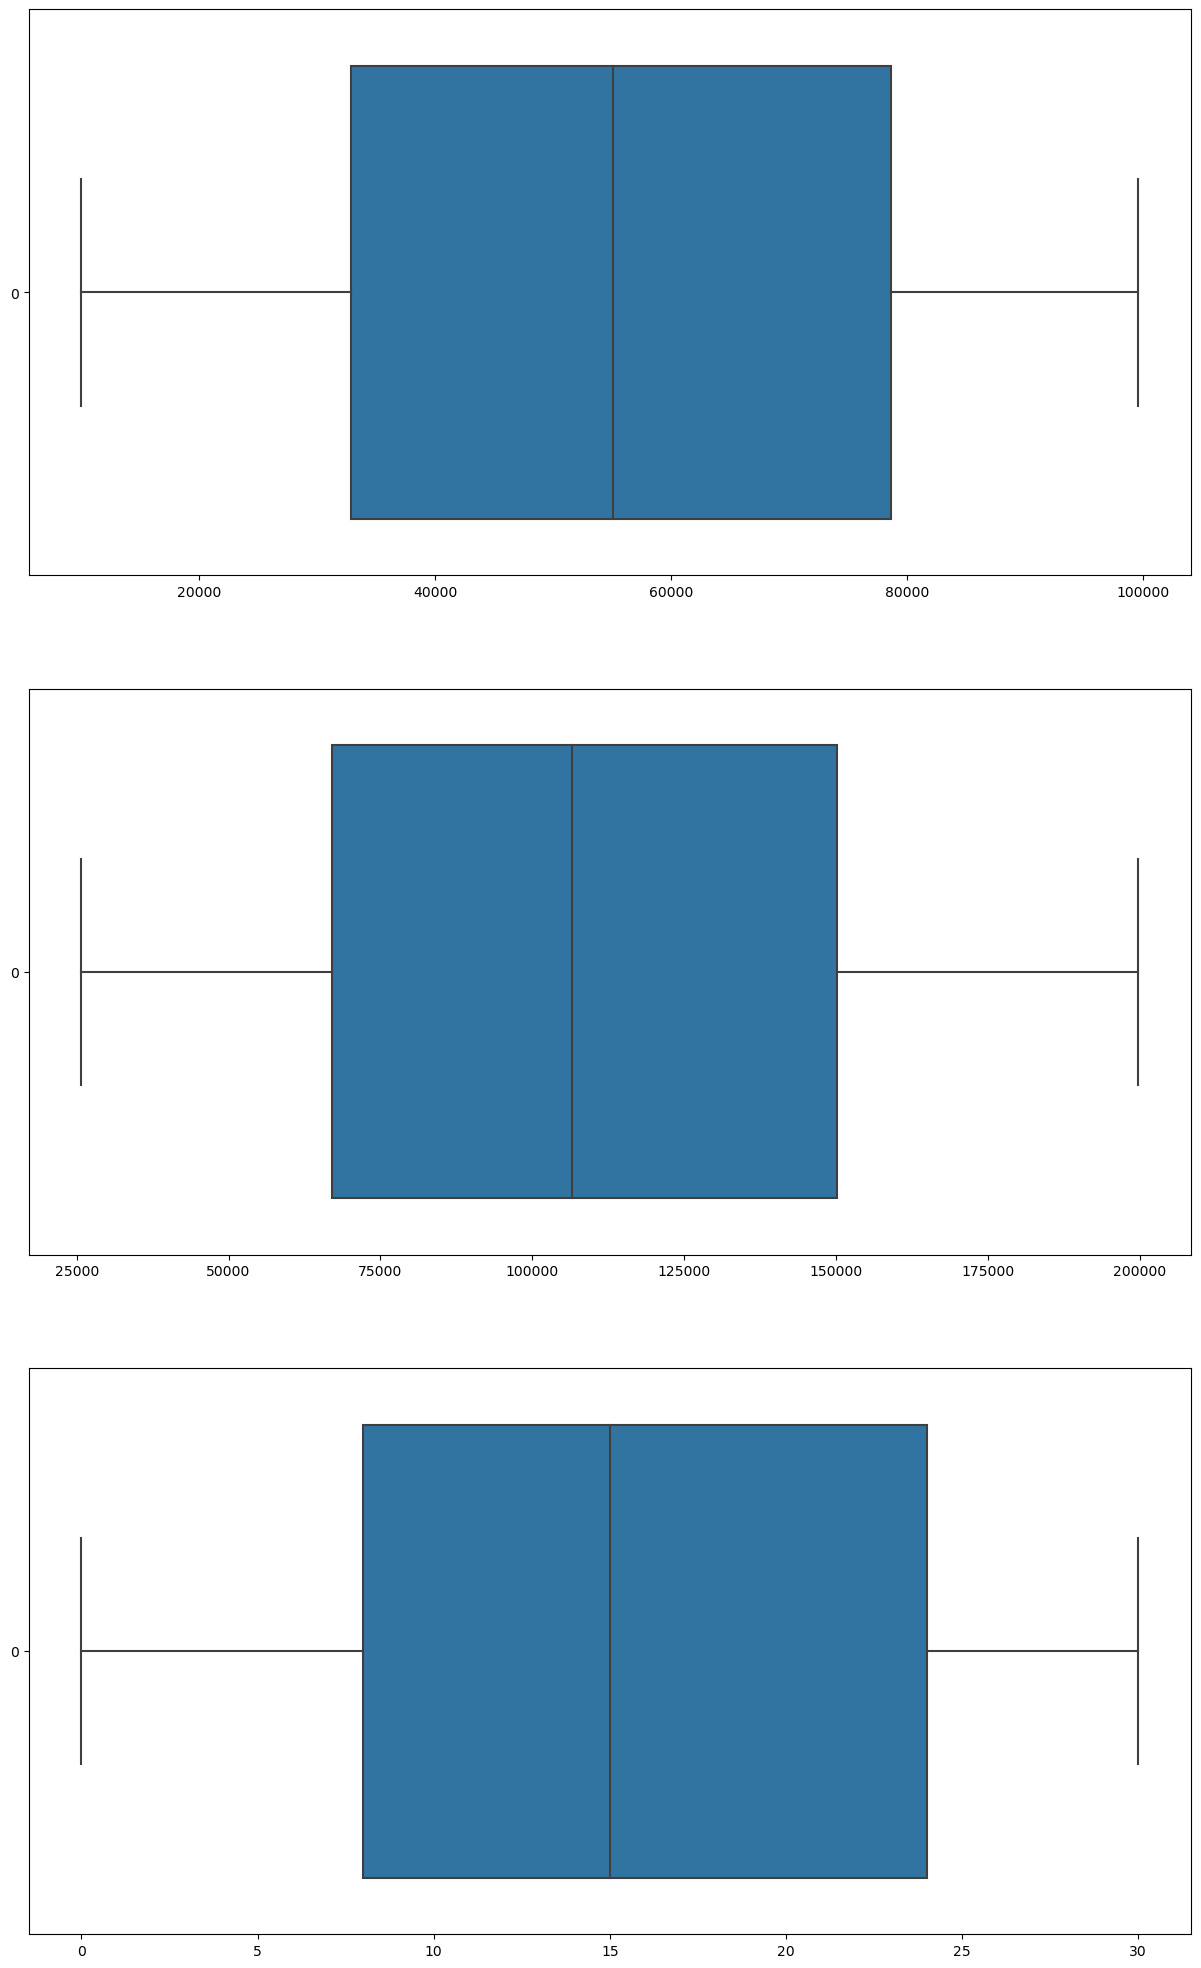

In [12]:
#Check for outliers
fig, ax =plt.subplots(3,1, figsize=(15,25)) 

sns.boxplot(fraud_data['Taxable.Income'] ,ax=ax[0],orient='h')
sns.boxplot(fraud_data['City.Population'] ,ax=ax[1],orient='h')
sns.boxplot(fraud_data['Work.Experience'] ,ax=ax[2],orient='h')


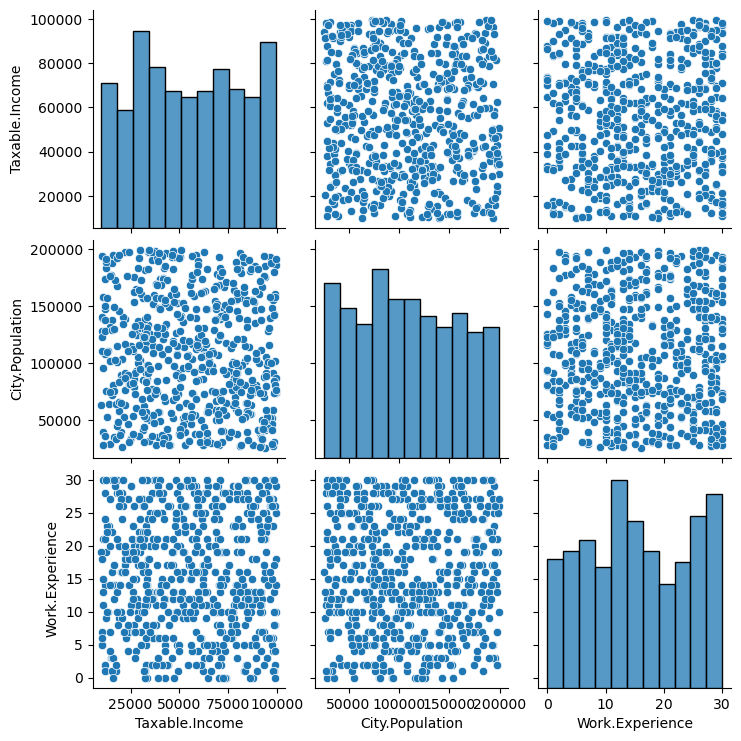

In [13]:
sns.pairplot(fraud_data)

In [14]:
fraud_data.corr()

,Taxable.Income,City.Population,Work.Experience
Taxable.Income,1.000000,-0.064387,-0.001818
City.Population,-0.064387,1.000000,0.013135
Work.Experience,-0.001818,0.013135,1.000000


<AxesSubplot: >

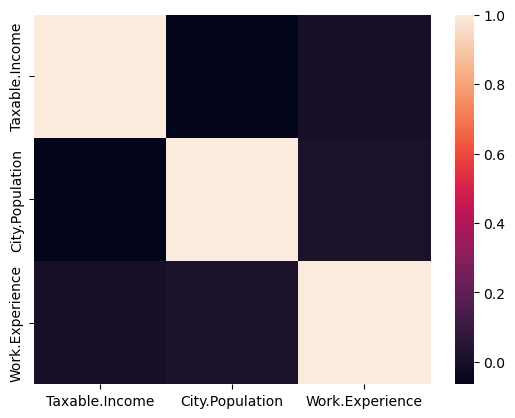

In [15]:
sns.heatmap(fraud_data.corr())

In [16]:
#Our target variable is Taxable.Income so we need to convert it into category type first
converted_data = fraud_data.copy()
converted_data['Taxable_Income_cat'] = pd.cut(x=converted_data['Taxable.Income'], bins = [10002,30000,99620], labels=['Risky','Good'], right = False)
converted_data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Taxable_Income_cat
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


<AxesSubplot: xlabel='Taxable_Income_cat', ylabel='count'>

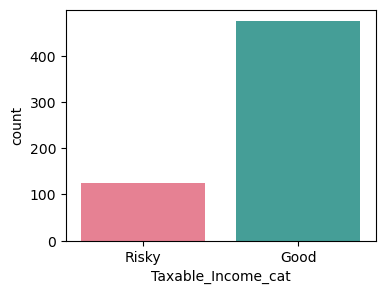

In [17]:
plt.figure(figsize=(4,3))
sns.countplot(x="Taxable_Income_cat", data=converted_data,palette="husl")

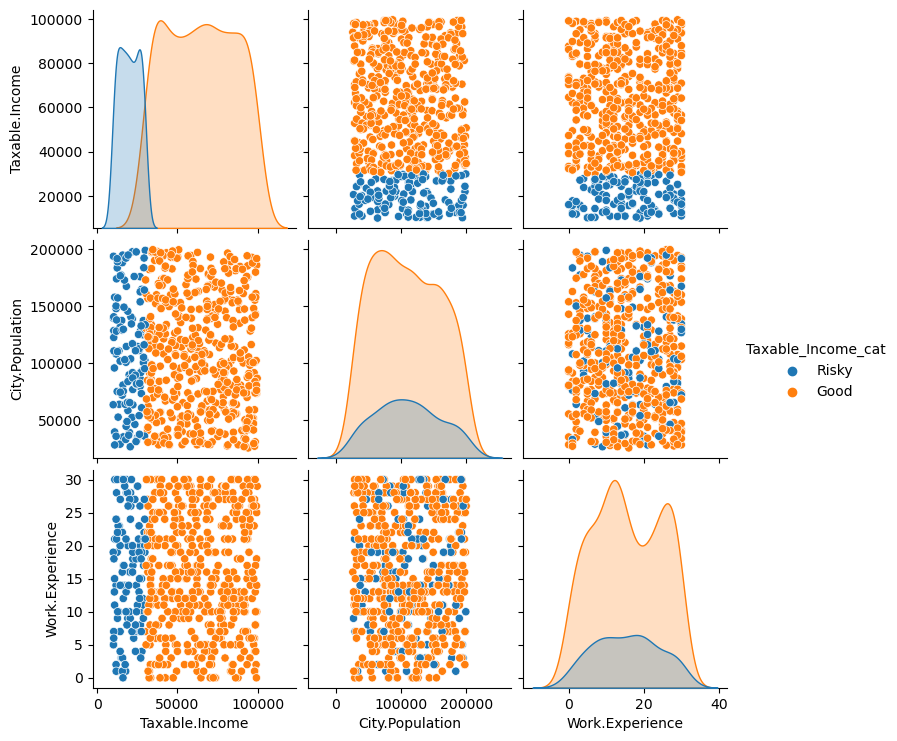

In [18]:
#relation with  Taxable_Income_cat with all other features
sns.pairplot(data=converted_data, hue = 'Taxable_Income_cat')

In [19]:
#Dropping Taxable.Income as we have the target as a Taxable_Income_cat
#creating dummies for the categorical variables
df_1 = converted_data.drop('Taxable.Income',axis=1)
df_1.head()

,Undergrad,Marital.Status,City.Population,Work.Experience,Urban,Taxable_Income_cat
0,NO,Single,50047,10,YES,Good
1,YES,Divorced,134075,18,YES,Good
2,NO,Married,160205,30,YES,Good
3,YES,Single,193264,15,YES,Good
4,NO,Married,27533,28,NO,Good


In [20]:
#label encoder for category features
encoder = LabelEncoder()
category_columns = ['Undergrad','Marital.Status','Urban','Taxable_Income_cat']
for col in category_columns:
    df_1[col] = encoder.fit_transform(df_1[col])
df_1.head()

,Undergrad,Marital.Status,City.Population,Work.Experience,Urban,Taxable_Income_cat
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


In [22]:
#Data Splitting
X = df_1.drop('Taxable_Income_cat',axis=1)
y = df_1['Taxable_Income_cat']

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=0)

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rf = RandomForestClassifier(random_state = 0)

In [26]:
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [27]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [28]:
rf_train_accuracy = accuracy_score(y_train,y_train_pred)
rf_test_accuracy = accuracy_score(y_test,y_test_pred)

In [29]:
print("training set accuracy:",rf_train_accuracy)
print("testing set accuracy:",rf_test_accuracy)

training set accuracy: 1.0
testing set accuracy: 0.78


In [37]:
#Hyperparameter tuning with RandomizedSearchCv
from sklearn.model_selection import RandomizedSearchCV
rf_1 = RandomForestClassifier(random_state=42)
parameters = {'max_depth':[int(x) for x in np.linspace(10, 110, num=11)],
              'n_estimators':[i for i in range(10, 200, 5)],
              'min_samples_leaf':[i for i in range(1, 10)],
              'criterion' :['gini', 'entropy'],
              'min_samples_split':[i for i in range(1, 10)],
              'max_features': ['auto', 'sqrt', 'log2']}
scorer = make_scorer(accuracy_score)

In [38]:
clf = RandomizedSearchCV(rf_1,parameters,cv=5,n_iter=10,scoring=scorer)

In [39]:
clf.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9],
                                        'n_estimators': [10, 15, 20, 25, 30, 35,
                                                         40, 45, 50, 55, 60, 65,
                                                         70, 75, 80, 85, 90, 95,
           

In [40]:
print(clf.best_params_)

{'n_estimators': 10, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'gini'}


In [45]:
#using these parameters building a Rarf = RandomForestClassifier(random_state = 0)ndom_Forest
model = RandomForestClassifier(n_estimators=10,
                               min_samples_split=9,
                               min_samples_leaf=7,
                               max_features='sqrt',max_depth=90,
                               criterion='gini',random_state=42)

In [46]:
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=90, max_features='sqrt', min_samples_leaf=7,
                       min_samples_split=9, n_estimators=10, random_state=42)

In [47]:
model_train_pred = model.predict(X_train)
model_test_pred = model.predict(X_test)

In [48]:
model_train_accuracy = accuracy_score(y_train,model_train_pred)
model_test_accuracy = accuracy_score(y_test,model_test_pred)

In [49]:
print("training set accuracy:",rf_train_accuracy)
print("testing set accuracy:",rf_test_accuracy)

training set accuracy: 1.0
testing set accuracy: 0.78


In [50]:
print(classification_report(y_test,model_test_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       119
           1       0.00      0.00      0.00        31

    accuracy                           0.79       150
   macro avg       0.40      0.50      0.44       150
weighted avg       0.63      0.79      0.70       150



In [52]:
importances = model.feature_importances_

In [53]:
feature_names = X_train.columns

In [54]:
feature_importances = pd.DataFrame({'feature':feature_names,'importance':importances})
feature_importances

,feature,importance
0,Undergrad,0.045597
1,Marital.Status,0.105091
2,City.Population,0.427092
3,Work.Experience,0.352659
4,Urban,0.069561


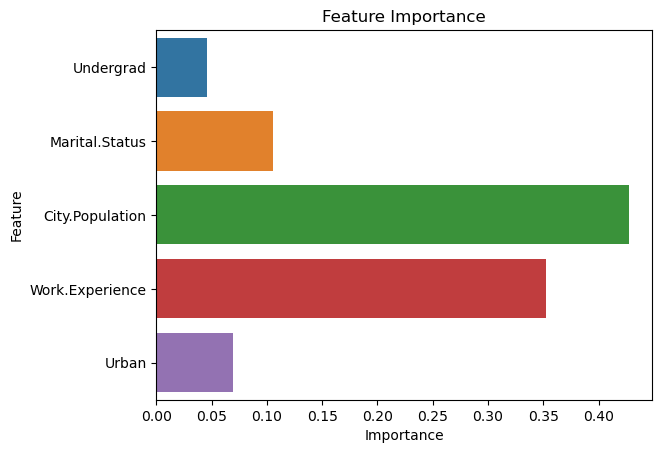

In [55]:
sns.barplot(x='importance',y='feature',data=feature_importances)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()